In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt




C:\Users\kulka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:

# Define data transformations for data augmentation and normalization
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [3]:
# Define the data directory
# data_dir = '../../Anchor_images/'
# data_dir = '../test/'

data_dir = './new_stuff/test/'

# Create data loaders
image_datasets = {x: datasets.ImageFolder(data_dir, data_transforms[x]) for x in ['test','train','val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['test']}
print(dataset_sizes)

class_names = image_datasets['test'].classes
print(class_names)
print(len(class_names))

{'test': 3097}
['attack', 'benign']
2


In [4]:
# pretrained_model = "custom_cnn_model_new_stuffing.pth"
pretrained_model = "custom_cnn_model_new_stuffing 1.pth"
# use_cuda=True
# Set random seed for reproducibility
# torch.manual_seed(42)
# Load the pre-trained ResNet-18 model
model = models.resnet18(pretrained=True)
# Freeze all layers except the final classification layer
# for name, param in model.named_parameters():
#     # Unfreeze the final classification layer
#     if "fc" in name:  
#         param.requires_grad = True
#     else:
#         param.requires_grad = False
# Modify the final layer to match the number of classes
num_classes = len(class_names)
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Move the model to the GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load(pretrained_model))
model.eval()
model = model.to(device)

print(device)

C:\Users\kulka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\kulka\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


cuda:0


In [7]:
test_loader = dataloaders['test']
# model.load_state_dict(torch.load(pretrained_model))

all_preds = []
all_labels = []

for inputs, labels in test_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

# Convert lists to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Calculate accuracy
test_accuracy = np.sum(all_preds == all_labels) / len(all_labels)
print(f'Test Accuracy: {test_accuracy:.4f}')

Test Accuracy: 0.9839


In [8]:
print(all_preds)
print(all_labels)

[0 0 0 ... 0 0 1]
[0 0 0 ... 0 0 1]


In [5]:
# FGSM attack code
def generate_mask(image, data_grad):
    # Assuming 'image' is of shape [batch_size, 3, 128, 128]
    # We need to identify the green channel which is the 2nd channel in this format

    # Extract the green channel
    green_channel = image[:, 1, :, :]
    
    # Create a mask for rows where all pixels are green (assuming green pixel values > 0.5)
    green_mask = green_channel > 0.5
    
    # Initialize variables to track the maximum gradient and corresponding row index
    max_grad = torch.zeros(green_channel.shape[0], device=image.device)
    max_grad_row = torch.zeros(green_channel.shape[0], dtype=torch.long, device=image.device)
    
    for i in range(green_channel.shape[1]):  # iterate over rows
        # Check if all pixels in the row are green
        all_green = green_mask[:, i, :].all(dim=1)
        
        # Compute gradient magnitude for the row
        row_grad_magnitude = data_grad[:, :, i, :].abs().sum(dim=(1, 2))
        
        # Update the row with max gradient magnitude if it has all green pixels
        update_mask = (row_grad_magnitude > max_grad) & all_green
        max_grad = torch.where(update_mask, row_grad_magnitude, max_grad)
        max_grad_row = torch.where(update_mask, torch.tensor(i, device=image.device), max_grad_row)

    # Create a mask to apply the sign data gradient only in the identified rows with max gradient
    mask = torch.zeros_like(data_grad)
    for b in range(image.shape[0]):
        mask[b, :, max_grad_row[b], :] = 1  # Applying on all columns of the identified row
    
    return mask

def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    
    # create a mask to apply sign data grad only in the row with max gradient magnitude
    mask = generate_mask(image, data_grad)

    sign_data_grad = sign_data_grad * mask

    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon * sign_data_grad

    # Ensure the identified row's pixels are either (0, 0, 0) or (256, 256, 256)
    for b in range(image.shape[0]):
        row = mask[b, 0].nonzero(as_tuple=True)[0]  # Identified row index
        if len(row) > 0:  # Only apply if a row is identified
            row = row[0].item()
            for col in range(image.shape[3]):
                pixel_value = perturbed_image[b, :, row, col]
                dot_product_with_1 = torch.dot(pixel_value, torch.tensor([1.0, 1.0, 1.0], device=image.device))
                dot_product_with_0 = torch.dot(pixel_value, torch.tensor([0.0, 0.0, 0.0], device=image.device))
                if dot_product_with_1 >= dot_product_with_0:
                    perturbed_image[b, :, row, col] = 1.0  # Set to (256, 256, 256) in range [0, 1]
                else:
                    perturbed_image[b, :, row, col] = 0.0  # Set to (0, 0, 0)

    # Adding clipping to maintain [0,1] range
    # perturbed_image = torch.clamp(perturbed_image, 0, 1)

    # Return the perturbed image
    return perturbed_image

# restores the tensors to their original scale
def denorm(batch, mean=[0.1307], std=[0.3081]):
    return batch
    """
    Convert a batch of tensors to their original scale.

    Args:
        batch (torch.Tensor): Batch of normalized tensors.
        mean (torch.Tensor or list): Mean used for normalization.
        std (torch.Tensor or list): Standard deviation used for normalization.

    Returns:
        torch.Tensor: batch of tensors without normalization applied to them.
    """
    if isinstance(mean, list):
        mean = torch.tensor(mean).to(device)
    if isinstance(std, list):
        std = torch.tensor(std).to(device)

    return batch * std.view(1, -1, 1, 1) + mean.view(1, -1, 1, 1)



In [16]:


def test( model, device, test_loader, epsilon ):
    test_loader = dataloaders['test']

    # Accuracy counter
    correct = 0
    adv_examples = []
    print(device)
    print(len(test_loader))
    all_preds = []
    all_labels = []
    # Loop over all examples in test set
    for data, target in test_loader:
        # print(target.shape)
        # print(target)
        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        model.eval()
        initial_output = model(data)
        # print(output)
        
        init_pred = initial_output.max(1, keepdim=True)[1] # get the index of the max log-probability
        # print(init_pred)
        # If the initial prediction is wrong, don't bother attacking, just move on
        # print(init_pred.item())
        # print(target.item())

        # if init_pred.squeeze().tolist() != target.tolist():
            # continue

        # Calculate the loss
        loss = F.nll_loss(initial_output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect ``datagrad``
        data_grad = data.grad.data

        # Restore the data to its original scale
        data_denorm = denorm(data)

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data_denorm, epsilon, data_grad)

        # Reapply normalization
        # perturbed_data_normalized = transforms.Normalize((0.1307,), (0.3081,))(perturbed_data)

        # Re-classify the perturbed image
        # output = model(perturbed_data_normalized)
        output = model(perturbed_data)
        # output = initial_output
        # print(output.shape)
        # print(output)
        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        # print("final: ", final_pred.item())

        all_preds.extend(final_pred.cpu().numpy())
        all_labels.extend(target.cpu().numpy())
        # if final_pred.squeeze().tolist() == target.tolist():
        #     correct += 1
        #     # Special case for saving 0 epsilon examples
        #     if epsilon == 0 and len(adv_examples) < 5:
        #         adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
        #         adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        # else:
        #     # Save some adv examples for visualization later
        #     if len(adv_examples) < 5:
        #         adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
        #         adv_examples.append( (init_pred.squeeze().tolist(), final_pred.squeeze().squeeze(), adv_ex) )

    # Calculate final accuracy for this epsilon
    # final_acc = correct/float(len(test_loader))
    # print(f"Epsilon: {epsilon}\tTest Accuracy = {correct} / {len(test_loader)} = {final_acc}")
    final_acc = np.sum(all_preds == all_labels) / len(all_labels)
    print(f'Test Accuracy: {final_acc:.4f}')

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples
# show an image


In [50]:
def calculate_accuracy2(all_preds, all_labels):
    # Count the number of correct predictions where label is 0
    correct = np.sum((all_preds == 0) & (all_labels == 0))
    
    # Count the total number of cases where label is 0
    total_cases = np.sum(all_labels == 0)
    
    # Calculate accuracy2
    if total_cases > 0:
        accuracy2 = correct / total_cases
    else:
        accuracy2 = 0.0  # Handle the case where there are no labels with value 0
    
    return accuracy2


def test2( model, device, test_loader, epsilon ):
    """
    accuracy is model incorrectly classifies benign + perturbation as benign image 
    """
    test_loader = dataloaders['test']

    # Accuracy counter
    correct = 0
    total_consider = 0
    adv_examples = []
    print(device)
    print(len(test_loader))
    all_preds = []
    all_labels = []
    # Loop over all examples in test set
    for data, target in test_loader:
        # print(target.shape)
        # print(target)
        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        model.eval()
        initial_output = model(data)
        # print(output)
        
        init_pred = initial_output.max(1, keepdim=True)[1] # get the index of the max log-probability
        # print(init_pred)
        # If the initial prediction is wrong, don't bother attacking, just move on
        # print(init_pred.item())
        # print(target.item())
        # if init_pred.squeeze().tolist() != target.tolist() or not all(element == 0 for element in target.tolist()):

        #     # print("not equal")
        #     continue
        total_consider +=1
        # Calculate the loss
        loss = F.nll_loss(initial_output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect ``datagrad``
        data_grad = data.grad.data

        # Restore the data to its original scale
        data_denorm = denorm(data)

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data_denorm, epsilon, data_grad)

        # Reapply normalization
        # perturbed_data_normalized = transforms.Normalize((0.1307,), (0.3081,))(perturbed_data)

        # Re-classify the perturbed image
        # output = model(perturbed_data_normalized)
        output = model(perturbed_data)
        # output = initial_output
        # print(output.shape)
        # print(output)
        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        # print("final: ", final_pred.item())

        all_preds.extend(final_pred.cpu().numpy())
        all_labels.extend(target.cpu().numpy())

        # if final_pred.squeeze().tolist() == target.tolist():
        #     correct += 1
        #     # Special case for saving 0 epsilon examples
        #     if epsilon == 0 and len(adv_examples) < 5:
        #         adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
        #         adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        # else:
        #     # Save some adv examples for visualization later
        #     if len(adv_examples) < 5:
        #         adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
        #         adv_examples.append( (init_pred.squeeze().tolist(), final_pred.squeeze().squeeze(), adv_ex) )

    # Calculate final accuracy for this epsilon
    # final_acc = correct/total_consider
    # print(f"Epsilon: {epsilon}\tTest Accuracy = {correct} / {total_consider} = {final_acc}")

    # final_acc = calculate_accuracy2(all_preds, all_labels)
    # print(f'Test Accuracy: {final_acc:.4f}')

    # Return the accuracy and an adversarial example
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    return all_preds.squeeze(), all_labels

# show an image


In [51]:
# print(preds.item())
# preds = [p[0].item() for p in preds]
preds = np.array(preds)
labels = np.array(labels)
preds = preds.squeeze()
acc = np.sum(preds == labels) / len(labels)
acc2 = calculate_accuracy2(preds, labels)

print(eps, acc, acc2)
print(preds)
print(labels)

1 0.9719082983532451 0.9557522123893806
[0 0 1 ... 1 1 0]
[0 0 1 ... 1 1 0]


In [52]:
print(preds==labels)

[ True  True  True ...  True  True  True]


In [53]:
accuracies = []
examples = []
epsilons = [ 0.1, 0.2, 0.4, 0.6, 0.8, 1]
epsilons.reverse()

test_loader = dataloaders['test']
# Run test for each epsilon
for eps in epsilons:
    # acc, ex = test2(model, device, test_loader, eps)
    print(eps)
    preds, labels = test2(model, device, test_loader, eps)
    acc = np.sum(preds == labels) / len(labels)
    ex = []
    acc2 = calculate_accuracy2(preds, labels)
    print(eps, acc, acc2)
    accuracies.append(acc)
    examples.append(ex)
    

1
cuda:0
775


In [ ]:
accuracies = []
examples = []
epsilons = [0.1, 0.2, 0.5, 1]

test_loader = dataloaders['test']
# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)


cuda:0
775


NameError: name 'test_accuracy' is not defined

torch.Size([3, 128, 128])
torch.Size([128, 128, 3])
tensor([[[0., 0., 0.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [0., 1., 0.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 1., 1., 1.]]])


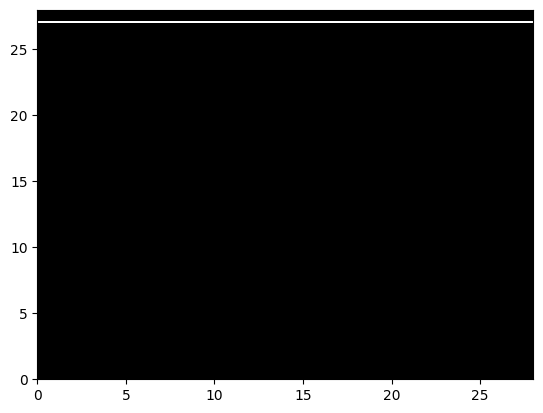

In [50]:

def generate_mask(image, data_grad):
    # Assuming 'image' is of shape [batch_size, 3, 128, 128]
    # We need to identify the green channel which is the 2nd channel in this format

    # Extract the green channel
    green_channel = image[:, 1, :, :]
    print(green_channel)
    # Create a mask for rows where all pixels are green (assuming green pixel values > 0.5)
    green_mask = green_channel > 0.5
    
    # Find the row with maximum gradient magnitude where all pixels are green
    max_grad = torch.zeros(green_channel.shape[0], device=image.device)
    max_grad_row = torch.zeros(green_channel.shape[0], dtype=torch.long, device=image.device)
    
    for i in range(green_channel.shape[2]):  # iterate over rows
        # Check if all pixels in the row are green
        all_green = green_mask[:, i, :].all(dim=1)
        
        # Compute gradient magnitude for the row
        row_grad_magnitude = data_grad[:, :, i, :].abs().sum(dim=(1, 2))
        
        # Update the row with max gradient magnitude if it has all green pixels
        update_mask = (row_grad_magnitude > max_grad) & all_green
        max_grad = torch.where(update_mask, row_grad_magnitude, max_grad)
        max_grad_row = torch.where(update_mask, torch.tensor(i, device=image.device), max_grad_row)

    # Create a mask to apply the sign data gradient only in the middle column of the identified row
    mask = torch.zeros_like(data_grad)
    for b in range(image.shape[0]):
        mask[b, :, max_grad_row[b], :] = 1  # Applying to all rows
        
    return mask
# show first image in dataset
img1 = dataloaders['test'].dataset[10][0]
print(img1.shape)
# print(img1)
print(img1.permute(1, 2, 0).shape)

plt.imshow(img1.permute(1, 2, 0), cmap='gray', interpolation='none', aspect='auto', extent=[0, 28, 0, 28])
# genarate mask and visualize it
img1 = img1.unsqueeze(0)
gradsss = torch.rand_like(img1).contiguous()
gradsss = gradsss-0.5
maskss = generate_mask(img1,gradsss)
plt.imshow(maskss.squeeze().permute(1, 2, 0), cmap='gray', interpolation='none', aspect='auto', extent=[0, 28, 0, 28])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


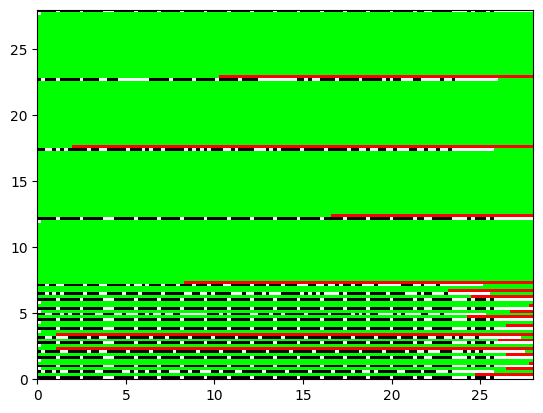

In [51]:
plt.imshow(gradsss.squeeze().permute(1, 2, 0), cmap='gray', interpolation='none', aspect='auto', extent=[0, 28, 0, 28])
plt.imshow(img1.squeeze().permute(1, 2, 0), cmap='gray', interpolation='none', aspect='auto', extent=[0, 28, 0, 28])


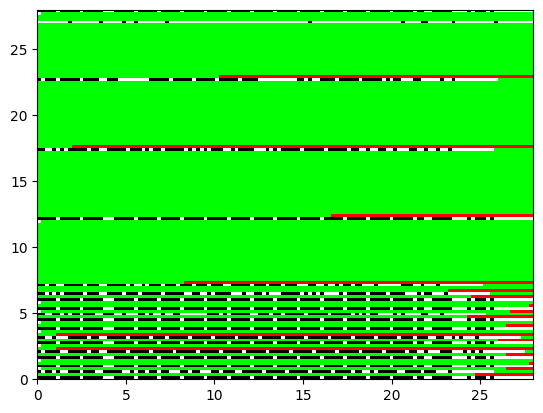

In [52]:
import torch

def generate_mask(image, data_grad):
    # Assuming 'image' is of shape [batch_size, 3, 128, 128]
    # We need to identify the green channel which is the 2nd channel in this format

    # Extract the green channel
    green_channel = image[:, 1, :, :]
    
    # Create a mask for rows where all pixels are green (assuming green pixel values > 0.5)
    green_mask = green_channel > 0.5
    
    # Initialize variables to track the maximum gradient and corresponding row index
    max_grad = torch.zeros(green_channel.shape[0], device=image.device)
    max_grad_row = torch.zeros(green_channel.shape[0], dtype=torch.long, device=image.device)
    
    for i in range(green_channel.shape[1]):  # iterate over rows
        # Check if all pixels in the row are green
        all_green = green_mask[:, i, :].all(dim=1)
        
        # Compute gradient magnitude for the row
        row_grad_magnitude = data_grad[:, :, i, :].abs().sum(dim=(1, 2))
        
        # Update the row with max gradient magnitude if it has all green pixels
        update_mask = (row_grad_magnitude > max_grad) & all_green
        max_grad = torch.where(update_mask, row_grad_magnitude, max_grad)
        max_grad_row = torch.where(update_mask, torch.tensor(i, device=image.device), max_grad_row)

    # Create a mask to apply the sign data gradient only in the identified rows with max gradient
    mask = torch.zeros_like(data_grad)
    for b in range(image.shape[0]):
        mask[b, :, max_grad_row[b], :] = 1  # Applying on all columns of the identified row
    
    return mask

def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    
    # create a mask to apply sign data grad only in the row with max gradient magnitude
    mask = generate_mask(image, data_grad)

    sign_data_grad = sign_data_grad * mask

    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon * sign_data_grad

    # Ensure the identified row's pixels are either (0, 0, 0) or (256, 256, 256)
    for b in range(image.shape[0]):
        row = mask[b, 0].nonzero(as_tuple=True)[0]  # Identified row index
        if len(row) > 0:  # Only apply if a row is identified
            row = row[0].item()
            for col in range(image.shape[3]):
                pixel_value = perturbed_image[b, :, row, col]
                dot_product_with_1 = torch.dot(pixel_value, torch.tensor([1.0, 1.0, 1.0], device=image.device))
                dot_product_with_0 = torch.dot(pixel_value, torch.tensor([0.0, 0.0, 0.0], device=image.device))
                if dot_product_with_1 >= dot_product_with_0:
                    perturbed_image[b, :, row, col] = 1.0  # Set to (256, 256, 256) in range [0, 1]
                else:
                    perturbed_image[b, :, row, col] = 0.0  # Set to (0, 0, 0)

    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)

    # Return the perturbed image
    return perturbed_image
pimg1 = fgsm_attack(img1, 1, gradsss)
plt.imshow(pimg1.squeeze().permute(1, 2, 0), cmap='gray', interpolation='none', aspect='auto', extent=[0, 28, 0, 28])


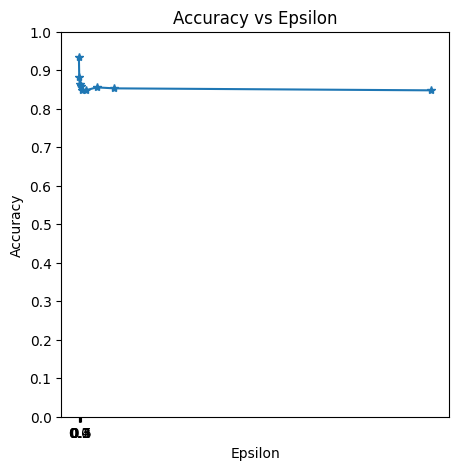

In [25]:
plt.figure(figsize=(5,5))
plt.plot(epsilons[:], accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, 0.6, step=0.1))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

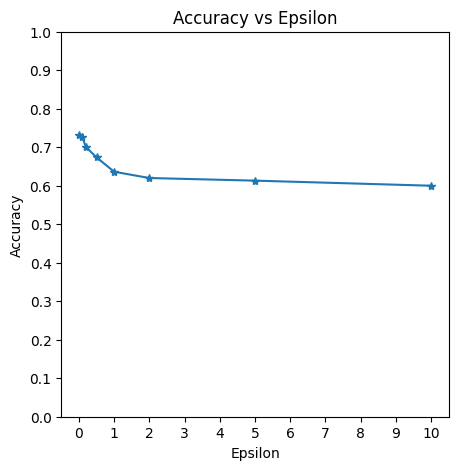

In [ ]:
# plot accuracy vs epsilon
accuracies2 = accuracies[:-1]
epsilons2 = epsilons[:-1]
accuracies2[5] = 0.62
accuracies2[7] = 0.6
plt.figure(figsize=(5,5))
plt.plot(epsilons2, accuracies2, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, 11, step=1))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()